# Организация набора данных для обучения сверточной нейросети классификации заболеваний дачных растений

## Основные зависимости
Для начала укажем все необходимые зависимости для работы с набором данных:
1. os - модуль Python для работы с файловой системой. Потребуется для поиска по структуре датасета;
2. random - модуль Python для генерации случайных чисел;
3. matplotlib.pyplot - библиотека для визуализации данных. Необходима для визуальных демонстраций различного назначения;
4. PIL - библиотека работы с изображениями;
5. shutil - модуль для операций с файлами и папками высокого уровня (копирование, перенос файлов и директорий);
6. imagehash - библиотека вычисления хешей изображений для поиска дубликатов;
7. tqdm - создание прогресс-баров в циклах для осущствления принципа ясного статуса системы;
8. albumentations - библиотека для аугментации изображений;
9. cv2 - библиотека компьютерного зрения. Пригодится для преобразования цветовых форматов;
10. numpy - библиотека для работы с числовыми массивами и матрицами, а также с функциями для выполнения математических и статистических операций (подсчет среднего и стандартного отклонения)

In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import imagehash
from tqdm import tqdm
import albumentations as A
import cv2
import numpy as np

## Этап 1 - Приобретение. Выбор обучающего набора данных
За основу будущего набора обучающих данных был выбран датасет Plant Diseases Classification [1], составленный выпускником Унивеситета Мансуры - Ahmed Ashraf Helmi. 
Разместим указанный набор в директории 'original_dataset'

In [2]:
raw_dataset = './original_dataset'

### Достоинства рассматриваемого набора данных для обучения

#### 1. Изображения сделаны в реальных условиях
Как отмечают авторы одного из обзоров [2] по используемым наборам данных для классификации заболеваний растений, наборы с изображениями, сделанным на однотонном фоне и приближенными к лабораторным условиям, едва применимы для классификации в реальных условиях. В свою очередь представленный набор содержит преимущественно изображения, сделанных в реальных условиях.

#### 2. Представленные заболевания и недуги растений являются актуальными как для садовдства, так и для сельского хозяйства России и мира в целом
В обучающем наборе помимо здоровых растений представлены следующие заболевания:
1. Мучнистая роса (Powdery Mildew)  является одной из наиболее распространённых и вредоносных патологий лиственных растений [3]. Это группа родственных грибов, которые поражают широкий спектр растений, вызывая появление белого пыльного налета на листьях, стеблях и цветах [4]. Заболевание поражает и сельскохозяйственные культуры: по статистике Cтавропольского Края на момент весны 2025 года было заражено более трети посевов [5].
2. Ржавчина (Rust) – это группа грибковых заболеваний, поражающих надземные части растений [6]. Заболевание приводит к некрозам и опухолевым процессам, что нарушает нормальную жизне деятельность растения и может привести к полной его гибели [7]. Если обратиться к сельскому хозяйству, то недобор урожая от бурой ржавчины может достигать 20-30% [8].
3. Повреждения слизнями (Slug) - Слизни являются многоядными вредителями, повреждающими свыше 150 видов и разновидностей культурных растений (полевых, кормовых, плодово-ягодных, овощных, технических и цветочно-декоративных [9]), выращиваемых в условиях открытого и закрытого грунта. Большой ущерб сельскому хозяйству они причиняют во всем мире [10].
4. Пятнистость листьев (Spot) - собирательное название для различных грибковых и бактериальных инфекций, вызывающих изменение цвета или появление пятен на листьях поражённых растений. Эти пятна могут различаться по размеру, цвету и форме и при серьёзном поражении могут представлять угрозу здоровью растения [11]. Одна из болезней, вызывающая пятнистотьб жёлтая пятнистоть, очень вредоностна. Потери урожая могут состовлять до 60% [12].

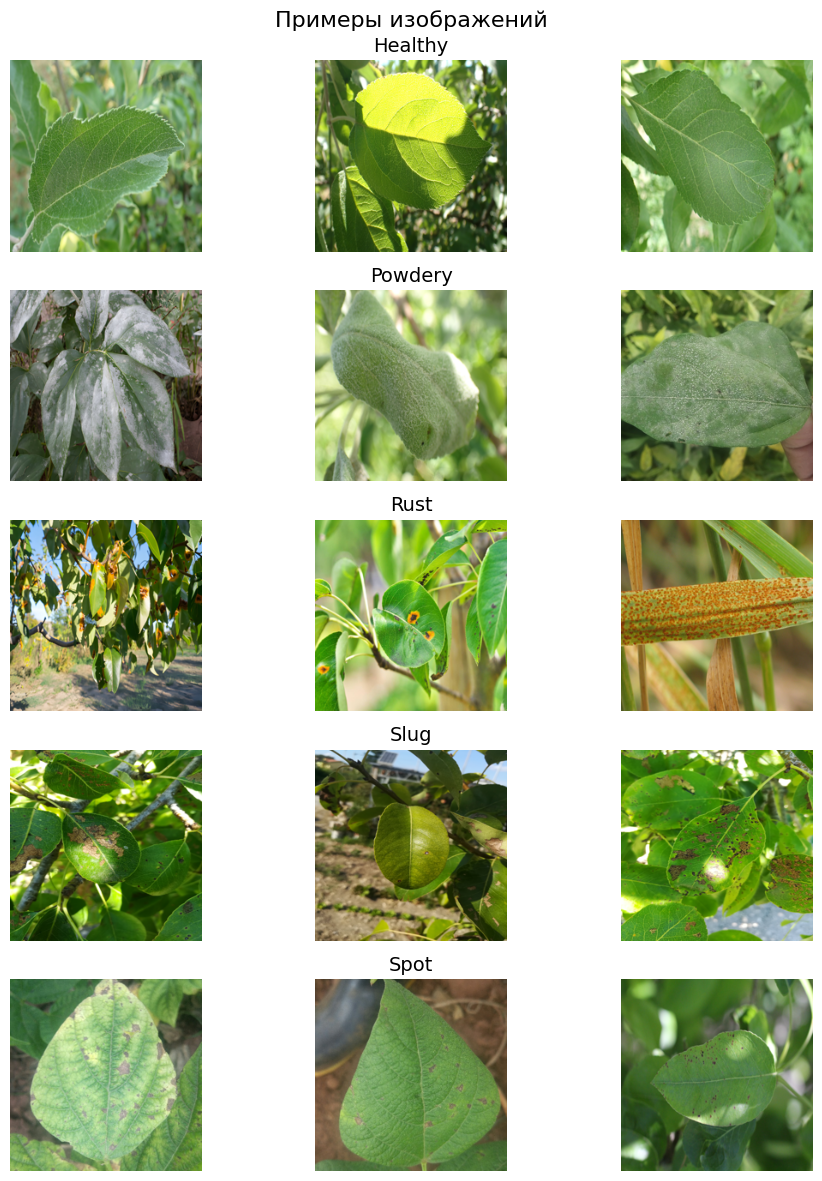

In [4]:
source_of_samples = os.path.join(raw_dataset, 'Test', 'Test')
classes = os.listdir(source_of_samples)

fig, axes = plt.subplots(len(classes), 3, figsize=(10, 12))
fig.suptitle("Примеры изображений", fontsize=16)

for row, cls in enumerate(classes):
    
    class_dir = os.path.join(source_of_samples, cls)
    images = os.listdir(class_dir)
    sample_imgs = random.sample(images, 3)
    
    for col, img_path in enumerate(sample_imgs):

        img_path = os.path.join(class_dir, img_path)
        img = Image.open(img_path)
        img = img.resize((224, 224))
        axes[row, col].imshow(img)
        axes[row, col].axis("off")

        if col == 1:
            axes[row, col].set_title(cls, fontsize=14)

plt.tight_layout()
plt.show()

#### 3. Набор cодержит достаточное число изображений для обучения
Количество экземпляров в каждом классе влияет на итоговое качество будущей нейросетевой модели [13,14], поэтому тренироваочная выборка должна иметь достатое колчиство изображений, иначе поведение модели будет напоминать случайное угадывание ответа. В обозреваемом датасете более 500 уникальных изображений для каждого класса.

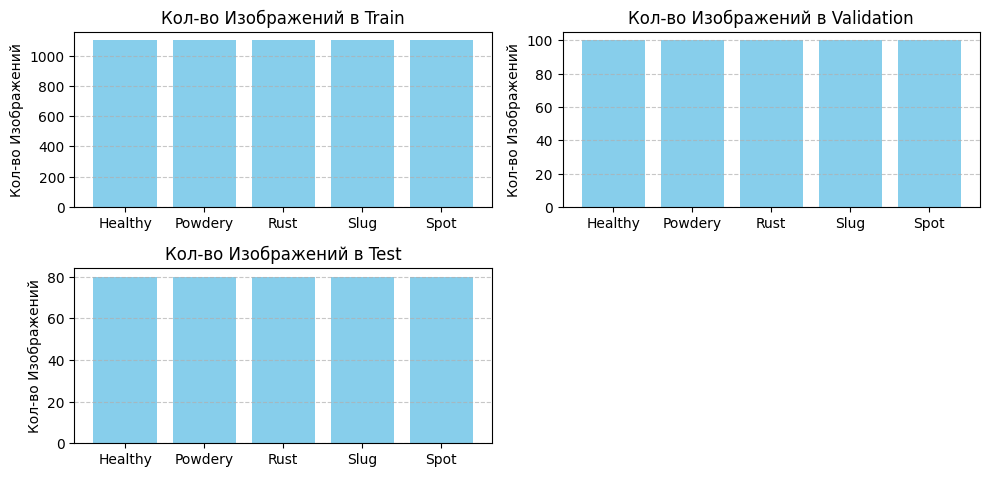

In [5]:
count = {}

plt.figure(figsize=(10, 7))

for i, dir in enumerate(['Train', 'Validation', 'Test']):

    result_path = os.path.join(raw_dataset, dir, dir)
    diseases = os.listdir(result_path)
    count[dir] = {}

    for disease in diseases:

        images = os.path.join(result_path, disease)
        count[dir][disease] = len(os.listdir(images))

    plt.subplot(3, 2, 1 + i)
    plt.bar(count[dir].keys(), count[dir].values(), color='skyblue')
    plt.ylabel('Кол-во Изображений')
    plt.title(f'Кол-во Изображений в {dir}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()

### Недостатки рассматриваемого набора данных для обучения

#### 1. Не все изображения принадлежат одному цветовому формату
Часть изображений являются 4х-канальными PNG изображениями. Также часть JPG изображений не являются таковыми, так как имеют 4 или 1 цветовой канал. Модели различных архитектур сверточных нейронных сетей принимают на вход тензоры строго определенного размера [15]. Подача изображений с разным числом каналов приведет к закономерной ошибке.

#### 2. Имеются визуальные дубликаты
В ходе визуальной испекции было замечено, что некоторые изображения были продублированы с целью достижения баланса классов. Эта техника является не самыми эффективным способом балансировки, так может привести к переобучению и снижению обобщающей способности модели [16]. Также появляется необходимость проверить, а не попали ли дубликаты из train выборки в validation и test, так как источники [17,18] дают рекомендацию исключить совпадения из train в validation и test, чтобы искусственно не завышать итоговую оценку модели.

### Промежуточный вывод на первом этапе
Выбранный датасет обладает ключевыми достоиствами, которых лишены многоие представленные в сети обучащие наборы. Выбранный датасет наполнен изображениям, выполненными в реальных условиях, их число достаточно для проведения обучения, а представленные классы актуальны для регионов России.
Несмотря на наличие недостатков, их можно устранить. Этому и будет посещена заключительная часть работы.

## Этап 2 - Представление / Формализация. Приведение датасета к привычной структуре
Перед устранением недостатков необходимо создать копию, с привычной структурой, с которой будут производиться работы по улучшени.

### Восстановление структуры директорий
Как можно заметить из структуры директорий оригинала, папки Train, Validation и Test, внутри себя содержат Train, Validation и Test, в которых только расположены классы заболеваний. Необходимо устранить такое дублирование

In [6]:
result_dataset = './result_dataset'

if not os.path.exists(result_dataset):
    os.mkdir(result_dataset)

In [7]:
for dir in ['Train', 'Validation', 'Test']:

    raw_path = os.path.join(raw_dataset, dir, dir)
    result_path = os.path.join(result_dataset, dir)

    if not os.path.exists(result_path):
        shutil.copytree(raw_path, result_path)

### Промежуточный вывод на втором этапе
Теперь структура директорий имеет привычный вид без необходимости дублирования названия в пути к набору
```
./.../Train/Train/... -> ./.../Train/...
./.../Validation/Validation/... -> ./.../Validation/...
./.../Test/Test/... -> ./.../Test/...
```

## Этап 3 - Валидация. Устранение недостатков

### Преобразование в RBG из RGBA и прочих
Начнем с обработки изображений с неверным количеством цветовых каналов. Изображения некорректных форматов будут преобразованы в RGB. Такое преобразование необходимо для того, чтобы у всех данных был единый формат входного тензора (3, ... , ...).

In [8]:
checked = 0
updated = 0

for root, dirs, files in os.walk(result_dataset):

    if len(files) > 0:
        files_loop = tqdm(files)

        for file in files_loop:
            file_path = os.path.join(root, file)

            format = 'RGB'

            with open(file_path, 'rb') as file:
                img = Image.open(file)
                format = img.mode
                    
            checked += 1

            if format != 'RGB':
                rgba_image = Image.open(file_path)  
                rgb_image = rgba_image.convert('RGB')  
                rgb_image.save(file_path)  

                updated += 1

            files_loop.set_description(f"Провека директории {root}")

print(f"Проверено файлов: {checked}")
print(f"Преобразовано в RGB: {updated}")

Провека директории ./result_dataset\Test\Spot: 100%|██████████| 80/80 [00:00<00:00, 139.99it/s]
Провека директории ./result_dataset\Train\Healthy: 100%|██████████| 1100/1100 [00:08<00:00, 123.32it/s]
Провека директории ./result_dataset\Train\Powdery: 100%|██████████| 1100/1100 [00:09<00:00, 118.31it/s]
Провека директории ./result_dataset\Train\Spot: 100%|██████████| 1100/1100 [00:09<00:00, 121.60it/s]
Провека директории ./result_dataset\Validation\Healthy: 100%|██████████| 100/100 [00:00<00:00, 118.87it/s]
Провека директории ./result_dataset\Validation\Powdery: 100%|██████████| 100/100 [00:00<00:00, 126.40it/s]
Провека директории ./result_dataset\Validation\Rust: 100%|██████████| 100/100 [00:00<00:00, 118.36it/s]
Провека директории ./result_dataset\Validation\Slug: 100%|██████████| 100/100 [00:00<00:00, 111.07it/s]
Провека директории ./result_dataset\Validation\Spot: 100%|██████████| 100/100 [00:00<00:00, 120.25it/s]

Проверено файлов: 6400
Преобразовано в RGB: 35


### Поиск и устранение дубликатов
Как было упомянуто ранее, наличие дубликтов, особенно между train и validation c test выборками, может негативно сказаться на формировании модели. Для устранения таковых дубликтов воспользуемся операцией хэша по изображению: изображения с одинаковыми хэшами являются визуальным дубликатами.

In [9]:
import matplotlib.image as mpimg

image_dir = result_dataset
image_hashes = {}
duplicates = {}

for root, dirs, files in os.walk(image_dir):

    if len(files) > 0:

        files_loop = tqdm(files, desc=f'Проверка директории {root}')

        for file in files_loop:
            file_path = os.path.join(root, file)

            with open(file_path, 'rb') as f:
                img = Image.open(file_path)
                value = imagehash.average_hash(img)

                if value in image_hashes:
                    if duplicates.get(image_hashes[value]) is None:
                        duplicates[image_hashes[value]] = []

                    duplicates[image_hashes[value]].append(file_path)
                else:
                    image_hashes[value] = file_path

            files_loop.set_description(f'Проверка директории {root}')

count_of_duplicates = sum([len(x) for x in duplicates.values()])
print("Найдено дубликатов:", count_of_duplicates)

Проверка директории ./result_dataset\Test\Healthy: 100%|██████████| 80/80 [00:03<00:00, 23.20it/s]
Проверка директории ./result_dataset\Test\Powdery: 100%|██████████| 80/80 [00:01<00:00, 45.07it/s] 
Проверка директории ./result_dataset\Test\Spot: 100%|██████████| 80/80 [00:01<00:00, 52.24it/s] 
Проверка директории ./result_dataset\Train\Healthy: 100%|██████████| 1100/1100 [00:47<00:00, 23.00it/s]
Проверка директории ./result_dataset\Train\Powdery: 100%|██████████| 1100/1100 [00:43<00:00, 25.07it/s]
Проверка директории ./result_dataset\Train\Spot: 100%|██████████| 1100/1100 [00:57<00:00, 19.17it/s]
Проверка директории ./result_dataset\Validation\Healthy: 100%|██████████| 100/100 [00:04<00:00, 23.40it/s]
Проверка директории ./result_dataset\Validation\Powdery: 100%|██████████| 100/100 [00:02<00:00, 35.06it/s]
Проверка директории ./result_dataset\Validation\Rust: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]
Проверка директории ./result_dataset\Validation\Slug: 100%|██████████| 100/10

Найдено дубликатов: 1334


Продемонстрируем несколько примеров найденных дубликатов, чтобы убедиться в том, что это копии друг друга.

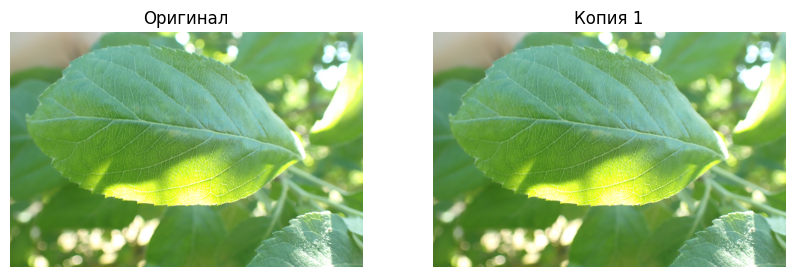

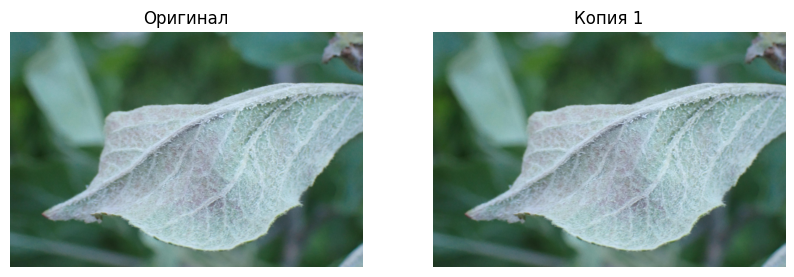

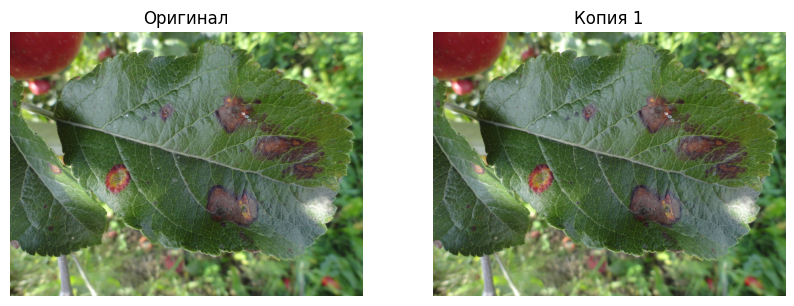

In [10]:
lst_of_duplicates = list(duplicates.items())
random.shuffle(lst_of_duplicates)
duplicates_iter = iter(lst_of_duplicates)

for i in range(3):
    key, copies = next(duplicates_iter)

    fig, axes = plt.subplots(1, 1 + len(copies), figsize=(10, 5))

    original_img = mpimg.imread(key)

    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title('Оригинал')

    for j, copy in enumerate(copies):
        copy_img = mpimg.imread(copy)
    
        axes[1 + j].imshow(copy_img)
        axes[1 + j].axis('off')
        axes[1 + j].set_title(f'Копия {j+1}')

plt.show()


Теперь удалим копии найденных изображений.

In [11]:
deleted = 0

duplicate_items = duplicates.items()
duplicate_items_loop = tqdm(duplicate_items)

for _, copies in duplicate_items_loop:
    for copy in copies:
        os.remove(copy)
        deleted += 1

    duplicate_items_loop.set_description("Удаление дубликатов")

print("Удалено дубликатов:", deleted)

Удаление дубликатов: 100%|██████████| 1334/1334 [00:01<00:00, 950.40it/s]

Удалено дубликатов: 1334


### Восстановление баланса классов в выборках
После проведенных мероприятий по устранению дублей, произошла разбалансировка классов. Необходимо устранить существующий дисбаланс, так как он влечет негативные последствия для процесса обучения [19,20], например, модель начинает больше ориентироваться на классы с наибольшим числом примеров и практически игнорирует малые классы.

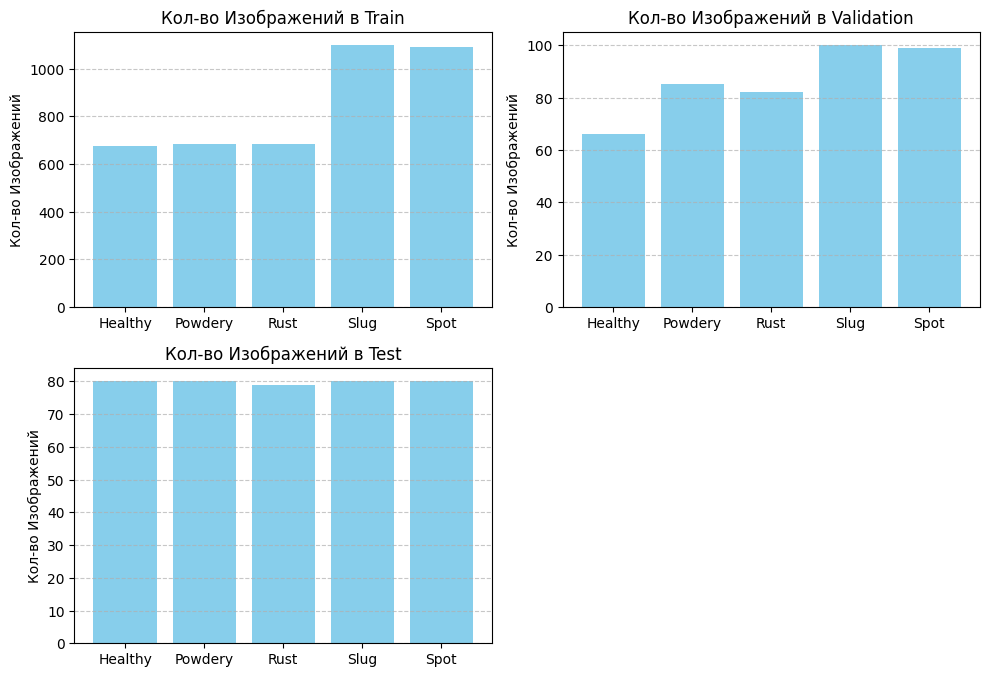

In [12]:
image_distribution = {}

plt.figure(figsize=(10, 10))

for i, dir in enumerate(['Train', 'Validation', 'Test']):
    
    result_path = os.path.join(result_dataset, dir)
    diseases = os.listdir(result_path)
    image_distribution[dir] = {}

    for disease in diseases:

        images = os.path.join(result_path, disease)
        image_distribution[dir][disease] = len(os.listdir(images))

    plt.subplot(3, 2, 1 + i)
    plt.bar(image_distribution[dir].keys(), image_distribution[dir].values(), color='skyblue')

    plt.ylabel('Кол-во Изображений')
    plt.title(f'Кол-во Изображений в {dir}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()

#### Дополнение Validation и Test
Из полученного результата видим, что баланс в Train и Validation выборках нарушен. Реализуем процедуру переноса части изображений из Train в Validation (и при желании в Test) для балансировки и/или увеличения доли Validation и Test выборок. Это может быть полезно, так как универсального соотношения между train/validation/test не выявлено [21].

План преобразования
Train
	Healthy: 677 --> 473
	Powdery: 683 --> 498
	Rust: 683 --> 494
	Slug: 1099 --> 929
	Spot: 1093 --> 922
Validation
	Healthy: 66 --> 200
	Powdery: 85 --> 200
	Rust: 82 --> 200
	Slug: 100 --> 200
	Spot: 99 --> 200
Test
	Healthy: 80 --> 150
	Powdery: 80 --> 150
	Rust: 79 --> 150
	Slug: 80 --> 150
	Spot: 80 --> 150


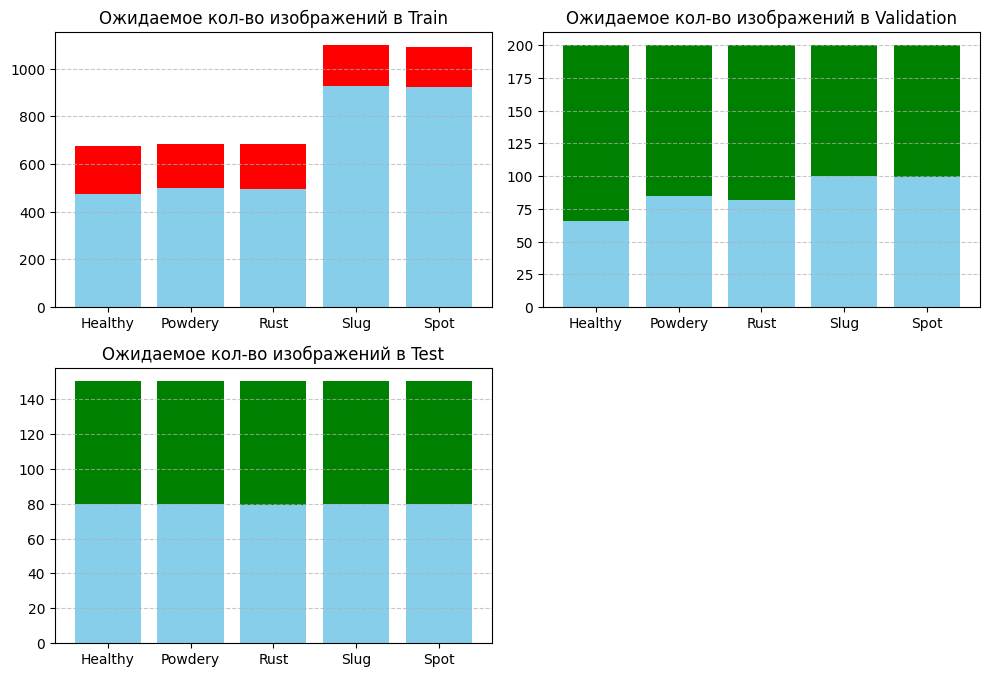

In [13]:
from_train2validation = {
    'Healthy': 134,
    'Powdery': 115,
    'Rust': 118,
    'Slug': 100,
    'Spot': 101,
}

from_train2test = {
    'Healthy': 70,
    'Powdery': 70,
    'Rust': 71,
    'Slug': 70,
    'Spot': 70,
}

result_distribution = {
    'Train': {},
    'Validation': {},
    'Test': {},
}

print("План преобразования")
print("Train")
train_distribution = image_distribution['Train']
for cls in train_distribution:
    before_rearranging = train_distribution[cls]
    after_rearranging = train_distribution[cls] - from_train2validation[cls] - from_train2test[cls]
    result_distribution['Train'][cls] = after_rearranging
    print(f'\t{cls}: {before_rearranging} --> {after_rearranging}')

print("Validation")
validation_distribution = image_distribution['Validation']
for cls in image_distribution['Validation']:
    before_rearranging = validation_distribution[cls]
    after_rearranging = validation_distribution[cls] + from_train2validation[cls]
    result_distribution['Validation'][cls] = after_rearranging
    print(f'\t{cls}: {before_rearranging} --> {after_rearranging}')


print("Test")
test_distribution = image_distribution['Test']
for cls in image_distribution['Test']:
    before_rearranging = test_distribution[cls]
    after_rearranging = test_distribution[cls] + from_train2test[cls]
    result_distribution['Test'][cls] = after_rearranging
    print(f'\t{cls}: {before_rearranging} --> {after_rearranging}')

plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.bar(train_distribution.keys(), train_distribution.values(), color='red')
plt.bar(result_distribution['Train'].keys(), result_distribution['Train'].values(), color='skyblue')
plt.title(f'Ожидаемое кол-во изображений в Train')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 2, 2)
plt.bar(result_distribution['Validation'].keys(), result_distribution['Validation'].values(), color='green')
plt.bar(validation_distribution.keys(), validation_distribution.values(), color='skyblue')
plt.title(f'Ожидаемое кол-во изображений в Validation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(3, 2, 3)
plt.bar(result_distribution['Test'].keys(), result_distribution['Test'].values(), color='green')
plt.bar(test_distribution.keys(), test_distribution.values(), color='skyblue')
plt.title(f'Ожидаемое кол-во изображений в Test')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Если представленный на графиках план преобразований устраивает, запустим процедуру преобразования:

In [14]:
for disease in train_distribution.keys():

    train_dir = os.path.join(result_dataset, 'Train', disease)
    validation_dir = os.path.join(result_dataset, 'Validation', disease)
    test_dir = os.path.join(result_dataset, 'Test', disease)

    images = os.listdir(train_dir)
    random.shuffle(images)

    for i in range(from_train2validation[disease]):
        image = os.path.join(train_dir, images[i])
        moved_image = os.path.join(validation_dir, f'mv-{images[i]}')
        shutil.move(image, moved_image)

    delta = from_train2validation[disease]

    for i in range(from_train2test[disease]):
        image = os.path.join(train_dir, images[delta + i])
        moved_image = os.path.join(test_dir, f'mv-{images[delta + i]}')
        shutil.move(image, moved_image)

Для проверки баланса можно запустить скрипт из начала текущего раздела

#### Балансировка Train
Теперь выполним балансировку тренировочной выборки. Для этого можно использовать технику аугментации. Можно применить разные подходы [22], например, подход weak-strong: для классов-меньшинств использовать более сильные аугментации, для классов-большинтсва - более слабые.

Чтобы опровобать подходы предлагаемые подходы, необходимо описать два вида трансформаций: сильные и слабые аугментации.

К набору слабых аугментаций (weak_aug) отнесем:
- Масштабирвание (RandomResizedCrop, Affine)
- Сдвиг (Affine)
- Поворот (RandomRotate90, Affine)
- Отражение (VerticalFlip, HorizontalFlip)

В набор сильнух аугментаций (strong_aug) войдут слабые и следующие:
- Изменение яркости и контрастности (RandomBrightnessContrast, CLAHE)
- Изменение оттенка (HueSaturationValue)
- Размытие (GaussianBlur)

In [15]:
strong_aug = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.75, 1.0), p=1),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.4),
    A.Affine(
        translate_percent=(0.15,0.15),
        scale=(0.75, 1.25),
        rotate=25,
        p=0.8
    ),
    A.RandomBrightnessContrast(0.3, 0.3, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.6),
    A.GaussianBlur(blur_limit=(1,3), p=0.3),
    A.CLAHE(clip_limit=3.0, p=0.3),
])

weak_aug = A.Compose([
    A.RandomResizedCrop((224, 224), scale=(0.9, 1.0), p=1),
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.2),
    A.Affine(
        translate_percent=(0.1, 0.1),
        scale=(0.9, 1.1),
        rotate=10,
        p=0.5
    ),
])

Теперь рализуем один из подходов - weak-strong.
Для классов с числом изображений около 500 применим по 3 сильных преобразования (для увеличения выборки с 500 до размеров 2000), для классов с числом изображений около 1000 - по 1 преобразованию умеренной силы (для доведения числа изображений с 1000 также до 2000). При желании можно изменить augmentation_scheduler и применить другие техники.

In [16]:
augmentation_scheduler = {
    'Healthy': (3, strong_aug),
    'Powdery': (3, strong_aug),
    'Rust': (3, strong_aug),
    'Spot': (1, weak_aug),
    'Slug': (1, weak_aug)
}

for disease, technique in augmentation_scheduler.items():
    multiplier, augment = technique

    path = os.path.join(result_dataset, 'Train', disease)
    images = os.listdir(path)
    images_loop = tqdm(images)

    for image in images_loop:

        img_path = os.path.join(path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for time in range(multiplier):
            
            augmented = augment(image=img)['image']
            out_path = os.path.join(path, f"augment_{time}_{image}")
            cv2.imwrite(out_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

        images_loop.set_description(f'Augmenting {disease}')

Augmenting Slug: 100%|██████████| 929/929 [01:00<00:00, 15.36it/s]


Для проверки баланса можно запустить скрипт из начала текущего раздела

### Промежуточный вывод на третьем этапе
В ходе валидации набора данных изображения были приведены к одному цветовому формату RGB, были устранены дубликаты изображений, а также налажен баланс в Train/Validation/Test. В результате выполненых преобразований были устранены изначальные недостатки исходного набора данных.

## Дополнительно. Подготовка к нормализации
Приведя датасет сет в валидное состояние, выполним некоторые подготовительные мероприятие перед будущим обучением, а именно рассчитаем среднее и стандартное отклонения, для проведения нормализации изображений, необходимой для процесса обучения [23].

In [17]:
def calculate_mean_std(image_dir, image_size=(224, 224)):
    sum_rgb = np.zeros(3)
    sum_sq_rgb = np.zeros(3)
    total_pixels = 0

    for root, _, files in os.walk(image_dir):
        if len(files) > 0:
            for f in tqdm(files, desc=f"Processing {root}"):
                image_path = os.path.join(root, f)
                img = Image.open(image_path).resize(image_size)
                img = np.array(img, dtype=np.float32) / 255.0  # нормализуем в [0,1]

                sum_rgb += img.sum(axis=(0, 1))
                sum_sq_rgb += (img ** 2).sum(axis=(0, 1))
                total_pixels += img.shape[0] * img.shape[1]

    mean = sum_rgb / total_pixels
    std = np.sqrt(sum_sq_rgb / total_pixels - mean ** 2)

    return mean, std

for dir in ('Train', 'Validation', 'Test'):
    image_dir = os.path.join(result_dataset, dir)
    mean, std = calculate_mean_std(image_dir)
    print(f"{dir} mean:", mean, "std:", std)
    print()

Processing ./result_dataset\Train\Spot: 100%|██████████| 1844/1844 [01:21<00:00, 22.68it/s] 


Train mean: [0.4062207  0.50391456 0.30175576] std: [0.24922806 0.26248565 0.24220641]



Processing ./result_dataset\Validation\Spot: 100%|██████████| 200/200 [00:11<00:00, 17.29it/s]


Validation mean: [0.45315444 0.55860809 0.32367048] std: [0.20922177 0.19994586 0.22421015]



Processing ./result_dataset\Test\Spot: 100%|██████████| 150/150 [00:06<00:00, 23.02it/s]

Test mean: [0.45004371 0.54905563 0.31683939] std: [0.21149614 0.2011135  0.21993101]



## Итоговый вывод
В ходе выполнения работы по подготовке обучающего набора данных, был выбран датасет, обладающий существенными преимуществами, которых нет среди прочих представленных датасетов. Имеющиеся при этом недостатаки не были критичными и поддавались исправлению. Так, теперь все изображения имеют 3 цветовых канала, датасет не имеет абсолютных копий, выборки Train/Validation/Test сбалансированы. Дополнительно посчитаны среднее и стандартное отклонение по цветовым каналам изображения, что необходимо для нормализации. Полученный набор данных пригоден для проведения обучения нейросетевой модели.

## Источники
1. www.kaggle.com - Plant Diseases Classification [Электронный ресурс]. - URL: <https://www.kaggle.com/datasets/ahmedashrafhelmi/plant-disease/data> (Дата обращения: 23.10.2025)
2. Ahmad A., Saraswat D., El Gamal A. A survey on using deep learning techniques for plant disease diagnosis and recommendations for development of appropriate tools // Smart Agricultural Technology. - 2023. - Т. 3. - 13 p. DOI [10.1016/j.atech.2022.100083](https://doi.org/10.1016/j.atech.2022.100083)
3. Кочергина М.В., Фурменкова Е.С. Мучнистая роса на объектах ландшафтной архитектуры города Воронежа // Лесотехнический журнал. - 2020. - №4(40). - Т. 10. С. 171-180. DOI: [10.34220/issn.2222-7962/2020.4/14](https://doi.org/10.34220/issn.2222-7962/2020.4/14)
4. www.rhs.org.uk - Powdery mildews [Электронный ресурс]. - URL: <https://www.rhs.org.uk/disease/powdery-mildews> (Дата обращения: 25.10.2025).
5. rsc26.ru - ФГБУ "Россельхозцентр": О результатах обследования мучнистой росы на зерновых колосовых культурах в РФ весной 2025 года [Электронный ресурс]. - URL: <https://rsc26.ru/press-tsentr/novosti/fgbu-rosselkhoztsentr-o-rezultatakh-obsledovaniya-muchnistoy-rosy-na-zernovykh-kolosovykh-kulturakh-/> (Дата обращения: 25.10.2025).
6. www.rhs.org.uk - Rust diseases [Электронный ресурс]. - URL: <https://www.rhs.org.uk/disease/rust-diseases> (Дата обращения: 225.10.2025).
7. Захарова  Н.В., Минеева Л. Ю. Анализ урединальной микобиоты растений ботанического сада ИвГУ и парка КиО им. Революции 1905 года // Актуальные проблемы биологии и экологии: материалы докладов XXX Всероссийской молодежной научной конференции (с элементами научной школы), посвященной 300-летию Российской академии наук. Сыктывкар, 2023. C. 21-24.
8. Аппаева Н.Н., Кудряшова Л.В., Ямалиева А.М. Развитие бурой ржавчины и содержание дубильных веществ в листьях яровой пшеницы // Вестник Марийского государственного университета. Серия "Сельскохозяйственные науки. Экономические науки". - 2016. - №2(6). С. 10-14.
9. Карпун Н.Н. Сортовая устойчивость гидрангеи крупнолистной к голым слизням и мучнистой росе в субтропиках краснодарского края // Вестник защиты растений. - 2014. - №2. С. 67-69.
10. http://vizrspb.ru/ - Слизни - вредители в садах и огородах [Электронный ресурс]. - URL: <http://vizrspb.ru/nashi-publikaczii/nauchno-populyarnyie-stati/slizni-vrediteli-v-sadax-i-ogorodax.html> (Дата обращения: 22.10.2025).
11. www.gardenia.net - Leaf spot diseases [Электронный ресурс]. - URL: <https://www.gardenia.net/disease/leaf-spot-diseases> (Дата обращения: 25.10.2025).
12. Ким Ю.С., Волкова Г.В. Желтая пятнистость листьев пшеницы: распространение, вредоносность, расовый состав (обзор) // Вестник Ульяновской государственной сельскохозяйственной академии. - 2020. - №2(50). С. 105-116. DOI: [10.18286/1816-4501-2020-2-105-116](https://doi.org/10.18286/1816-4501-2020-2-105-116)
13. Hestness J. Deep Learning Scaling is Predictable, Empirically / J. Hestness, S. Narang, N. Ardalani, G. F. Diamos, H. Jun, H. Kianinejad, M. Ali Patwary, Y. Yang, Y. Zhou. // arXiv preprint arXiv:1712.00409. - 2017. - 17 с. DOI: [10.48550/arXiv.1712.00409](https://doi.org/10.48550/arXiv.1712.00409)
14. Bahri Y. Explaining neural scaling laws / Y. Bahri, E. Dyer, J. Kaplan, J. Lee, U. Sharma // Proceedings of the National Academy of Sciences of the United States of America. - 2024. - Vol. 121. - №27. - 8 p. DOI: [10.1073/pnas.2311878121](https://doi.org/10.1073/pnas.2311878121)
15. Goodfellow I., Bengio Y. Courville A. Deep learning. - Cambridge, MA: MIT Press, 2016. - 775 p. - ISBN 0262035618. - URL: <https://www.deeplearningbook.org/>
16. Kong L. Evaluation of Effective Class‑Balancing Techniques for CNN‑Based Assessment of Aphanomyces Root Rot Resistance in Pea (Pisum sativum L.) / L. Kong, L. Yu, X. Liu, H. Wang, D. Xu. // Sensors. - 2022. - Vol. 22. - № 19. - 17 p. DOI: [10.3390/s22197237](https://doi.org/10.3390/s22197237)
17. Barz B., Denzler J. Do We Train on Test Data? Purging CIFAR of Near‑Duplicates // Journal of Imaging. - 2020. - Vol. 6. - № 6. - 8 p. - DOI: [10.3390/jimaging6060041](https://doi.org/10.3390/jimaging6060041)
18. developers.google.com - Datasets: Dividing the original dataset [Электронный ресурс]. - URL: <https://developers.google.com/machine-learning/crash-course/overfitting/dividing-datasets?utm_source=chatgpt.com>
19. Leevy J.L. A survey on addressing high-class imbalance in big data / J.L. Leevy, T.M. Khoshgoftaar, R.A. Bauder, N. Seliya // Journal of Big Data. - 2018. - №5, 42. - 30 p. DOI: [10.1186/s40537-018-0151-6](https://doi.org/10.1186/s40537-018-0151-6)
20. Johnson J.M., Khoshgoftaar T.M. Survey on deep learning with class imbalance // Journal of Big Data. - 2019 №6, 27. - 54 p. DOI: [10.1186/s40537-019-0192-5](https://doi.org/10.1186/s40537-019-0192-5)
21. Arafin P., Issa A., Billah A H M M. Performance Comparison of Multiple Convolutional Neural Networks for Concrete Defects Classification // Sensors (Basel). - 2022. - №22. - 18 p. DOI: [10.3390/s22228714](https://doi.org/10.3390/s22228714)
22. Schaudt D. Augmentation strategies for an imbalanced learning problem on a novel COVID-19 severity dataset / D. Schaudt, R. von Schwerin, A. Hafner, P. Riedel, M. Reichert, M. von Schwerin, M. Beer, C. Kloth // Scientific Reports. - 2023. №13, 18299. - 16 p. DOI: [10.1038/s41598-023-45532-2](https://doi.org/10.1038/s41598-023-45532-2)
23. Rashad М., Mansour M., Taha M. An Efficient Approach for Automatic Melanoma Detection Based on Data Balance and Deep Neural Network // Journal of Computing and Communication. - 2024. - №1. - Vol. 3. P. 22-32. DOI: [10.21608/jocc.2024.339917](https://doi.org/10.21608/jocc.2024.339917)